In [ ]:
import os
import cv2
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import transforms
from utils_winter import CLIPModel
import matplotlib.pyplot as plt



In [ ]:
numbers = 0

In [ ]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

device = 'cpu'
model = CLIPModel().to(device)
model_path = 'best_autumn_margin_1.pt'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

d_encoder = model.drone_encoder
s_encoder = model.satellite_encoder


del(model)


def image_to_vector(image, encoder):

    image_tensor = transform(image).unsqueeze(0).to(device)
    _, features = encoder(image_tensor)
    features = features.cpu().detach().numpy().flatten()
    return features

def calculate_cosine_similarity(vector1, vector2):
    cosine_sim = cosine_similarity([vector1], [vector2])[0][0]
    return cosine_sim

def get_image_paths(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(('.png', '.tif'))]

def display_image_pairs(pairs, title):
    fig, axes = plt.subplots(len(pairs), 2, figsize=(10, 5 * len(pairs)))
    fig.suptitle(title, fontsize=20)

    for i, (base_name, path1, path2, cosine_sim) in enumerate(pairs):
        image1 = Image.open(path1).convert('RGB')
        image2 = Image.open(path2).convert('RGB')

        axes[i, 0].imshow(image1)
        axes[i, 0].set_title(f"{base_name} - {os.path.basename(path1)}\nCosine Similarity: {cosine_sim:.4f}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(image2)
        axes[i, 1].set_title(f"{base_name} - {os.path.basename(path2)}\nCosine Similarity: {cosine_sim:.4f}")
        axes[i, 1].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def compute_image_pairs_similarity(folder):
    image_paths = get_image_paths(folder)

    images = {}
    for path in image_paths:
        base_name = os.path.splitext(os.path.basename(path))[0]
        if base_name not in images:
            images[base_name] = []
        images[base_name].append(path)

    cosine_similarities = []
    similarity_details = []

    for base_name, paths in images.items():
        if len(paths) == 2:
            path1, path2 = paths
            image1 = Image.open(path1).convert('RGB')
            image2 = Image.open(path2).convert('RGB')

            if path1.endswith('.tif'):
                vector1 = image_to_vector(image1, s_encoder)
            else:
                vector1 = image_to_vector(image1, d_encoder)

            if path2.endswith('.tif'):
                vector2 = image_to_vector(image2, s_encoder)
            else:
                vector2 = image_to_vector(image2, d_encoder)

            cosine_sim = calculate_cosine_similarity(vector1, vector2)
            cosine_similarities.append(cosine_sim)
            similarity_details.append((base_name, path1, path2, cosine_sim))

    if cosine_similarities:
        average_cosine_sim = sum(cosine_similarities) / len(cosine_similarities)
    else:
        average_cosine_sim = 0

    print(f"平均余弦相似度: {average_cosine_sim}")

    cosine_similarities.sort()
    threshold_90 = np.percentile(cosine_similarities, 90)
    print(f"\n90% cosine similarity threshold: {threshold_90}")

    y_true = [1 if sim > threshold_90 else 0 for sim in cosine_similarities]
    y_pred = [1] * len(cosine_similarities)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"accuracy: {accuracy}")
    print(f"precision: {precision}")
    print(f"recall: {recall}")
    print(f"F1 score: {f1}")

    similarity_details.sort(key=lambda x: x[3])
    lowest_similarity_pairs = similarity_details[:3]
    highest_similarity_pairs = similarity_details[-3:]

    display_image_pairs(lowest_similarity_pairs, "2 pairs of images with the lowest cosine similarity")
    display_image_pairs(highest_similarity_pairs, "2 pairs of images with the highest cosine similarity")

    return average_cosine_sim


平均余弦相似度: 0.09518203511834145

90% cosine similarity threshold: 0.1258396789431572
accuracy: 0.1036036036036036
precision: 0.1036036036036036
recall: 1.0
F1 score: 0.1877551020408163


/tmp/ipykernel_10188/4085225816.py:58: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipykernel_10188/4085225816.py:58: UserWarning: Glyph 20855 (\N{CJK UNIFIED IDEOGRAPH-5177}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipykernel_10188/4085225816.py:58: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipykernel_10188/4085225816.py:58: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipykernel_10188/4085225816.py:58: UserWarning: Glyph 20302 (\N{CJK UNIFIED IDEOGRAPH-4F4E}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipykernel_10188/4085225816.py:58: UserWarning: Glyph 20313 (\N{CJK UNIFIED IDEOGRAPH-4F59}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipyke

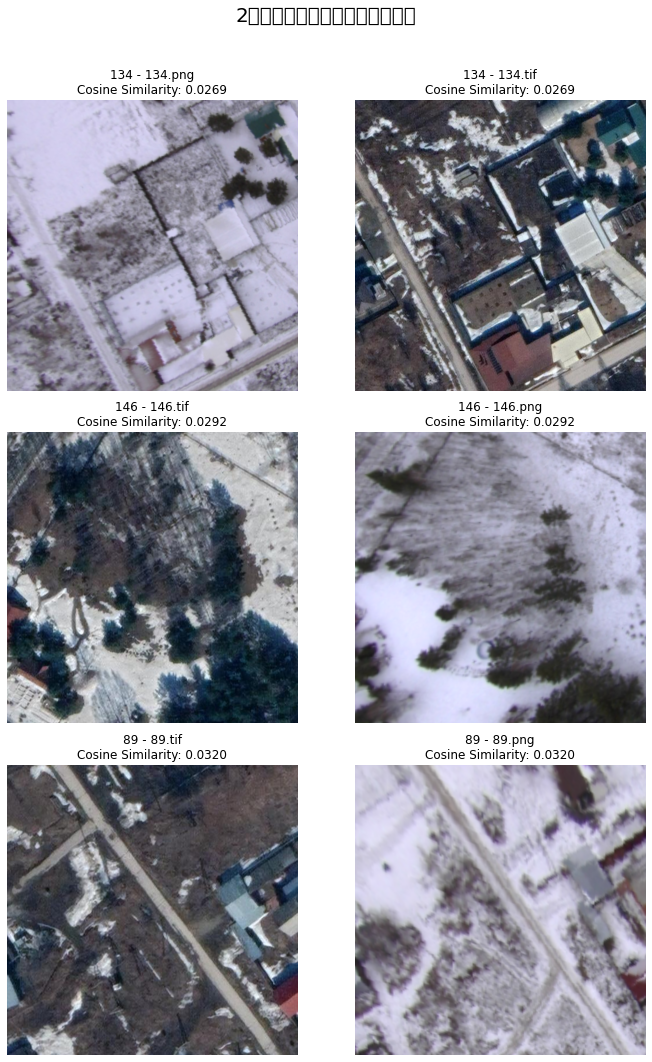

/tmp/ipykernel_10188/4085225816.py:58: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


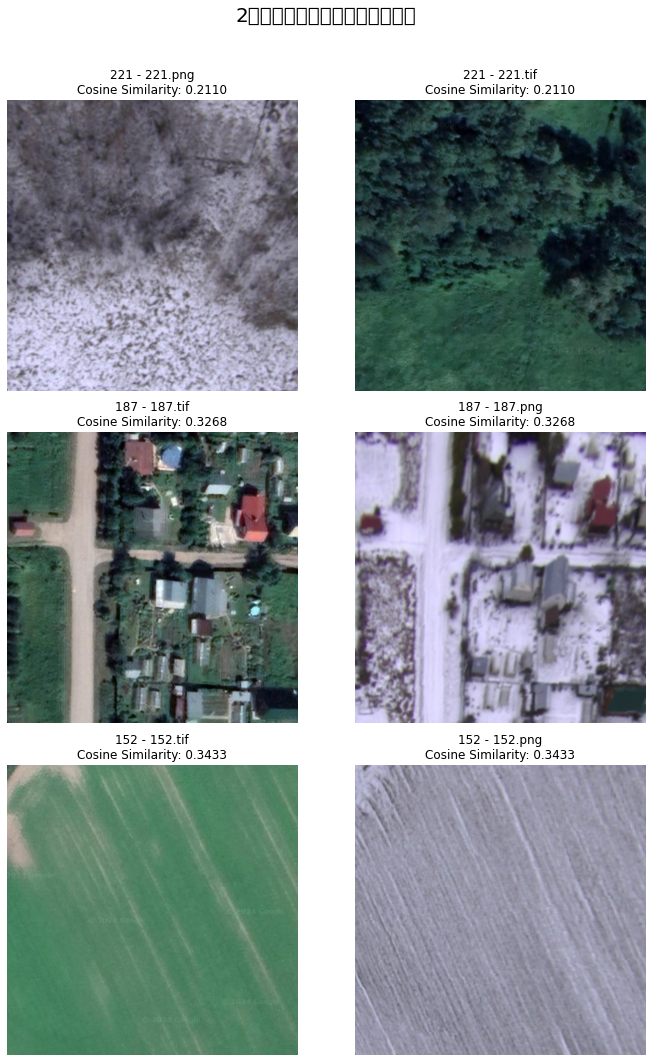

In [ ]:
if __name__ == "__main__":
    folder = "vkr_images/04-Copy1.02.24_prepared_data"

    compute_image_pairs_similarity(folder)

In [ ]:
print(numbers)

0
